In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [26]:
ppp = pd.read_csv('../data/cleaned_1and2_reduced.csv')
ppp.head()

,SBAOfficeCode,ProcessingMethod,BorrowerZip,LoanStatus,Term,SBAGuarantyPercentage,InitialApprovalAmount,CurrentApprovalAmount,ServicingLenderLocationID,RuralUrbanIndicator,...,PAYROLL_PROCEED,MORTGAGE_INTEREST_PROCEED,RENT_PROCEED,REFINANCE_EIDL_PROCEED,HEALTH_CARE_PROCEED,DEBT_INTEREST_PROCEED,BusinessType,OriginatingLenderLocationID,Gender,Veteran
0,156,PPP,06853-1207,1,24,100,18457.00,18457.00,9551,U,...,18457.00,0.0,0.0,0.0,0.0,0.0,Limited Liability Company(LLC),9551,Unanswered,Unanswered
1,156,PPP,06107-2103,1,24,100,18457.00,18457.00,9551,U,...,18457.00,0.0,0.0,0.0,0.0,0.0,Corporation,9551,Female Owned,Unanswered
2,156,PPS,06278-1421,1,60,100,18456.65,18456.65,93682,R,...,18450.65,0.0,0.0,0.0,0.0,0.0,Limited Liability Company(LLC),93682,Female Owned,Non-Veteran
3,156,PPP,06357-1742,1,60,100,18456.00,18456.00,93490,U,...,18455.00,0.0,0.0,0.0,0.0,0.0,Single Member LLC,93490,Male Owned,Non-Veteran
4,156,PPP,06111-2212,1,60,100,18455.00,18455.00,433860,U,...,18455.00,0.0,0.0,0.0,0.0,0.0,Corporation,529111,Unanswered,Unanswered


What is our full parameter set?

In [27]:
num_code_features = ['SBAOfficeCode', 'ServicingLenderLocationID', 'NAICSCode', 'OriginatingLenderLocationID']

for p in num_code_features:
    ppp[p] = ppp[p].astype(str)

In [28]:
# numeric columns
numeric_features = ppp.dtypes[ppp.dtypes != 'object']
numeric_features

LoanStatus                     int64
Term                           int64
SBAGuarantyPercentage          int64
InitialApprovalAmount        float64
CurrentApprovalAmount        float64
JobsReported                   int64
UTILITIES_PROCEED            float64
PAYROLL_PROCEED              float64
MORTGAGE_INTEREST_PROCEED    float64
RENT_PROCEED                 float64
REFINANCE_EIDL_PROCEED       float64
HEALTH_CARE_PROCEED          float64
DEBT_INTEREST_PROCEED        float64
dtype: object

A number of parameters are being misinterpreted as numerical because the information is a numeric code, say for the ServicingLenderLocationID.  These should be corrected to categorical.

In [29]:
# Include all  numeric features
subset_cols = numeric_features.index.to_list()
subset_cols

['LoanStatus',
 'Term',
 'SBAGuarantyPercentage',
 'InitialApprovalAmount',
 'CurrentApprovalAmount',
 'JobsReported',
 'UTILITIES_PROCEED',
 'PAYROLL_PROCEED',
 'MORTGAGE_INTEREST_PROCEED',
 'RENT_PROCEED',
 'REFINANCE_EIDL_PROCEED',
 'HEALTH_CARE_PROCEED',
 'DEBT_INTEREST_PROCEED']

In [30]:
categorical_features = ppp.dtypes[ppp.dtypes == 'object'].index.to_list()
categorical_features

['SBAOfficeCode',
 'ProcessingMethod',
 'BorrowerZip',
 'ServicingLenderLocationID',
 'RuralUrbanIndicator',
 'HubzoneIndicator',
 'LMIIndicator',
 'BusinessAgeDescription',
 'CD',
 'NAICSCode',
 'Race',
 'Ethnicity',
 'BusinessType',
 'OriginatingLenderLocationID',
 'Gender',
 'Veteran']

In [31]:
# To speed up computation, work with reduced dimensionality
# Add back categorical features as we tune
cat_cols = ['BusinessType', 'RuralUrbanIndicator', 'LMIIndicator', 'HubzoneIndicator', 'BusinessAgeDescription', 'Race', 'Ethnicity', 'Gender', 'Veteran']
subset_cols = subset_cols + cat_cols
subset_cols

['LoanStatus',
 'Term',
 'SBAGuarantyPercentage',
 'InitialApprovalAmount',
 'CurrentApprovalAmount',
 'JobsReported',
 'UTILITIES_PROCEED',
 'PAYROLL_PROCEED',
 'MORTGAGE_INTEREST_PROCEED',
 'RENT_PROCEED',
 'REFINANCE_EIDL_PROCEED',
 'HEALTH_CARE_PROCEED',
 'DEBT_INTEREST_PROCEED',
 'BusinessType',
 'RuralUrbanIndicator',
 'LMIIndicator',
 'HubzoneIndicator',
 'BusinessAgeDescription',
 'Race',
 'Ethnicity',
 'Gender',
 'Veteran']

Previously we included categorical data which describe business profile and the communities they operate in.  We also included demographic information about the business ownders.

A number of additional categories may be of interest.

In [32]:
second_set_cats =[f for f in categorical_features if f not in subset_cols]
second_set_cats

['SBAOfficeCode',
 'ProcessingMethod',
 'BorrowerZip',
 'ServicingLenderLocationID',
 'CD',
 'NAICSCode',
 'OriginatingLenderLocationID']

NAICSCode describes the type of industry the business is in, such as hospitality or cosmetics.
This is likely to be very important information.

ProcessingMethod indicates if this loan is from the first or second draw PPP loans.  This is likely to be relevant as second draw loans were only issued to businesses with first draw loans which  may be indicative of improving financial health.  It depends on how businesses were evaluated to qualify for second draw loans.

CD indicates the Congressional District of the borrower.  Since we dropped data pertaining to the geographic location of the businesses, this is a way to indirectly represent geolocation data, as well as encapsulate attributes of the socioeconomic profile of where these businesses operate as well as connecting our results potentially to policy differences.

The servicing and originating lenders are uniquely identified by LocationID.  This information may be predictive as these private lending institutions have their own criteria for evaluating businesses for loans and practices for supporting the borrowers which may influence the loan outcome.

In [33]:
subset_cols = subset_cols + ['ProcessingMethod', 'ServicingLenderLocationID', 'OriginatingLenderLocationID']

Add in NAICSCode

In [34]:
subset_cols = subset_cols + ['NAICSCode']

Add in Congressional District (CD)

In [35]:
subset_cols = subset_cols + ['CD']

Add in Borrower Zip (similar data offered to CD)

In [36]:
subset_cols = subset_cols + ['BorrowerZip']

In [37]:
subset_ppp = ppp[subset_cols]
subset_ppp.columns

Index(['LoanStatus', 'Term', 'SBAGuarantyPercentage', 'InitialApprovalAmount',
       'CurrentApprovalAmount', 'JobsReported', 'UTILITIES_PROCEED',
       'PAYROLL_PROCEED', 'MORTGAGE_INTEREST_PROCEED', 'RENT_PROCEED',
       'REFINANCE_EIDL_PROCEED', 'HEALTH_CARE_PROCEED',
       'DEBT_INTEREST_PROCEED', 'BusinessType', 'RuralUrbanIndicator',
       'LMIIndicator', 'HubzoneIndicator', 'BusinessAgeDescription', 'Race',
       'Ethnicity', 'Gender', 'Veteran', 'ProcessingMethod',
       'ServicingLenderLocationID', 'OriginatingLenderLocationID', 'NAICSCode',
       'CD', 'BorrowerZip'],
      dtype='object')

In [38]:
# Define X and y
X = subset_ppp.drop(columns=['LoanStatus'])
y = subset_ppp['LoanStatus']

In [39]:
X.shape[1]

27

Deciding on a train-val-test split proportion
A rule of thumb is that the validation set fraction should be inversely proportional to the log2 of the number of free adjustable parameters.

In [40]:
print(f'{round((1 / np.sqrt(X.shape[1])*100), 2)}% should be reserved for validation')

19.25% should be reserved for validation


In [41]:
print(f'{round(((1 - 1 / np.sqrt(X.shape[1]))*100), 2)}% should be used for training')

80.75% should be used for training


In [42]:
baseline_accuracy = y.value_counts(normalize=True)[1]
y.value_counts(normalize=True)

LoanStatus
1    0.908
0    0.092
Name: proportion, dtype: float64

### Preprocessing 
#### OneHotEncoder to dummify the categorical features

In [43]:
# Make a list of categorical features
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

In [44]:
# len(subset_ppp['BusinessType'].unique())

In [45]:
# Preprocessing pipeline for categorical features
preprocessor = ColumnTransformer(transformers=[
    ('oh', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)  
])

In [46]:
# Define the Random Forest model with preprocessing and classifier
# Use default tuning parameters
rf = RandomForestClassifier(n_estimators=5, max_depth=3, )

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', rf)
])

In [47]:
# Perform train test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [48]:
# Split training set further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [49]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('oh',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['BusinessType',
                                                   'RuralUrbanIndicator',
                                                   'LMIIndicator',
                                                   'HubzoneIndicator',
                                                   'BusinessAgeDescription',
                                                   'Race', 'Ethnicity',
                                                   'Gender', 'Veteran',
                                                   'ProcessingMethod',
                                                   'ServicingLenderLocationID',
                                                   'OriginatingLenderLocationID',
                                                   'NAICSCode', 'CD',
                                                   'BorrowerZip']),
                                                 ('num', StandardScaler(),
                                                  ['Term',
                                                   'SBAGuarantyPercentage',
                                                   'InitialApprovalAmount',
                                                   'CurrentApprovalAmount',
                                                   'JobsReported',
                                                   'UTILITIES_PROCEED',
                                                   'PAYROLL_PROCEED',
                                                   'MORTGAGE_INTEREST_PROCEED',
                                                   'RENT_PROCEED',
                                                   'REFINANCE_EIDL_PROCEED',
                                                   'HEALTH_CARE_PROCEED',
                                                   'DEBT_INTEREST_PROCEED'])])),
                ('rf', RandomForestClassifier(max_depth=3, n_estimators=5))])

In [50]:
pipe.score(X_train, y_train)

0.9079474501307111

In [51]:
pipe.score(X_val, y_val)

0.9087121177047935

In [52]:
# Delete this! Just peeking at holdout data
# pipe.score(X_test, y_test) # 0.9108

We remark that after splitting data to create a holdout set, performance apparently reduced from score 0.92 to 0.91.  However, we are still working with a very small subset of the features.  We expect that after we add more columns back, and potentially concatenate more of the PPP loans from the rest of the 5GB datset, we will see restoration of Validation Set accuracy.  This is an important thing to do because we want to be able to have greater confidence in interpreting the efficacy of our model on holdout (unseen) data.

In [53]:
# Reassemble the feature names so that we can map these correctly to feature importances

transformed_feature_names = pipe.named_steps['preprocessor'].named_transformers_['oh']      .get_feature_names_out(categorical_cols).tolist()
all_feature_names = transformed_feature_names + numerical_cols
len(all_feature_names)

663453

In [54]:
# Get feature importances from the trained model
feature_importances = pipe.named_steps['rf'].feature_importances_
len(feature_importances)

663453

In [55]:
# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})
sorted_importances = importance_df.sort_values(by='Importance', ascending=False)
top_features = sorted_importances[sorted_importances['Importance'] > 0]
top_features

,Feature,Importance
5106,OriginatingLenderLocationID_69819,0.162327
6936,NAICSCode_999990,0.149183
2302,ServicingLenderLocationID_71727,0.129181
1192,ServicingLenderLocationID_368915,0.116784
7065,CD_VA-11,0.081150
104895,BorrowerZip_32807-3752,0.071136
147906,BorrowerZip_33054-2126,0.047417
446587,BorrowerZip_76549-5649,0.041608
249159,BorrowerZip_33565-3610,0.041608
450691,BorrowerZip_76706-7332,0.039344


In [56]:
# Examine y predictions
y_pred = pipe.predict(X_val)
pd.Series(y_pred).value_counts(normalize=True)

1    1.0
Name: proportion, dtype: float64

In [57]:
# Examine the confusion matrix
cm = confusion_matrix(y_val, y_pred)

In [58]:
print(cm)

[[     0  29577]
 [     0 294420]]


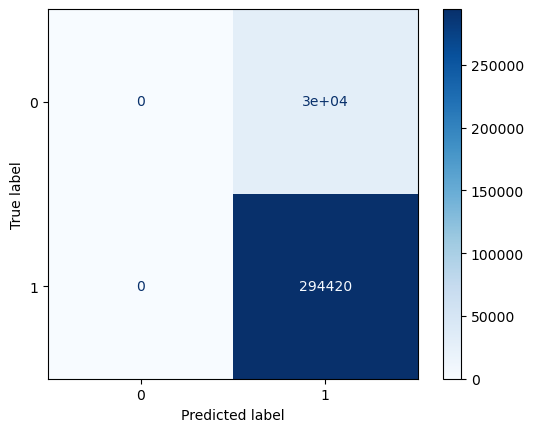

In [59]:
ConfusionMatrixDisplay.from_estimator(pipe, X_val, y_val, cmap='Blues');

In [60]:
# Compute overall accuracy from confusion matrix
overall_accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()

In [61]:
# Calculate precision, recall, and F1-score for each class
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
# recall = cm.diagonal() / (cm.sum(axis=1) + 1)
# f1_score = 2 * (precision * recall) / (precision + recall)

In [62]:
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
# print(f"Recall (Sensitivity): {recall}")
# print(f"F1-Score: {f1_score}")

Overall Accuracy: 0.9087
Baseline Accuracy: 0.9080
Precision: 0.9087


# TO-DO >>>

## Data cleaning
~~collapse target into binary~~

## Holdout - best practices 
~~split train val test 80 10 10~~

### Improving performance
## The numerical columns
~~0) add all numeric features back in~~
1) feature engineer multicollinear PROCEEDS variables

## Feature engineering to handle categorical features
exclude categorical vals where there are too many unique values

how to narrow down cat cols:
1) engineer feature to reduce number of unique values by doing top 5, and 'other'
   
~~2) ordinal labeling~~

3) examine feature importance and drop least important, then retrain

### Downsample as needed until it finishes within reasonable time

## Scale back up to more data 
Google colab for scale up

# Optional
cross-validation -- why do we do this
~~no need to boostrap resample, sufficient to binarize~~
~~NN keras~~

## Other kinds of models to try
### Ensembling an ensemble could be interesting
0) RandomForest
1) XGBoost
2) knn
3) SVM
4) Multilayer perceptron NN - fewer hyperparameters

# Recall

which category the early high performing model had
and examine the feature importances, and restructure that data to reduce categories